## Transfer Learning -- Use Residual network for classification (pretrained on ImageNet) 
- AlexNet competed in the ImageNet Large Scale Visual Recognition Challenge on September 30, 2012.
- [List of models in pytorch](https://pytorch.org/vision/stable/models.html)
- Read: https://arxiv.org/abs/1512.03385

 ``Prepared by Sharib Ali, PhD``

In [1]:
import torch
import torchvision.models as models
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in /cdthome/hfk218/.cache/torch/hub/pytorch_vision_v0.10.0


In [2]:
import numpy as np
from torchvision import transforms 
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [3]:
# Load data and include prepared transform (Remember to apply same transform to both train 
# and test data)
trainset = CIFAR10("data", download=True, train=True, transform=transform)
testset = CIFAR10("data", download=True, train=False, transform=transform)

# labels of CIFAR10 dataset
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Step: Split between train and valset from the overall trainset
from torch.utils.data.sampler import SubsetRandomSampler
val_percentage = 0.1
num_train = len(trainset)

indices = list(range(num_train))
split = int(np.floor(val_percentage * num_train))

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# Now create data loaders (same as before)
# Now we need to create dataLoaders that will allow to iterate during training
batch_size = 64 # create batch-based on how much memory you have and your data size

traindataloader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
valdataloader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler,
            num_workers=2,)

testdataloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print('Number of training samples:', len(traindataloader))
print('Number of validation samples:', len(valdataloader))
print('Number of testing samples:', len(testdataloader))

Number of training samples: 704
Number of validation samples: 79
Number of testing samples: 2500


In [5]:
#Model description
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
#Updating the second classifier (changing last fully connected layer)
import torch.nn as nn
model.fc =  nn.Linear(512,10)

In [7]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
# Recall acccuracy calculation
# define accuracy
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [10]:
# 1] create your optimiser
import torch.optim as optim
learning_rate = 0.001 # Note: this is an important hyperparameter
model = model.to(device)
optimiser = optim.SGD(model.parameters(), lr = learning_rate,weight_decay=1e-6, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [11]:
# Step: Define training function
from torch.utils.tensorboard import SummaryWriter
import time # to check computation time
def train(device, traindataloader, model, criterion, epochs, log_interval, tensorboardLogFile='AlexNet_Retrain'):
    losses_df = {'train_loss' : [], 'train_acc' : [], 'val_loss' : [], 'val_acc' : []}
    print('running on...', device)
    model.to(device)
    model.train() #retrain the entire network
    writer = SummaryWriter()
    
    for epoch in range(epochs):
        start_time = time.time()
        train_loss, valid_loss, train_top1,val_top1  = [], [], [], []
        for batch_idx, (data, label) in enumerate(traindataloader):
            # initialise all your gradients to zero
            optimiser.zero_grad()
            out = model(data.to(device))
            loss = criterion(out, label.to(device))
            loss.backward()
            optimiser.step()

            # append
            train_loss.append(loss.item())
            acc_1 = topk_accuracy(out, label.to(device),topk=(1,))
            train_top1.append(acc_1[0].item())
            


            if (batch_idx % log_interval) == 0:
                print('Train Epoch is: {}, train loss is: {:.6f}, train accuracy top1% is {}'.format(epoch, np.mean(train_loss),
                                                                                               np.mean(train_top1)))

        # every epoch write the loss and accuracy (these you can see plots on tensorboard)  

        
                with torch.no_grad():
                    for i, (data, label) in enumerate(valdataloader):
                        data, label = data.to(device), label.to(device)
                        out = model(data)
                        loss = criterion(out, label.to(device))
                        # append
                        valid_loss.append(loss.item())
                        acc_1 = topk_accuracy(out, label.to(device),topk=(1,))
                        val_top1.append(acc_1[0].item())

                print('Val Epoch is: {}, val loss is: {:.6f}, val accuracy top1% is {}'.format(epoch, np.mean(valid_loss),
                                                                                               np.mean(val_top1)))
        writer.add_scalar(tensorboardLogFile+'/train_loss', np.mean(train_loss), epoch)
        writer.add_scalar(tensorboardLogFile+'/train_accuracy', np.mean(train_top1), epoch)
        end_time = time.time()
        print('time taken for epoch{} is {},'.format(epoch, end_time - start_time))
        
        # training loss, val loss and val accuracy
        losses_df['train_loss'].append(np.mean(train_loss))
        losses_df['train_acc'].append(np.mean(train_top1))
        losses_df['val_loss'].append(np.mean(valid_loss))
        losses_df['val_acc'].append(np.mean(val_top1))
              
    print('Finished!')
    return losses_df

In [12]:
# Step: Define test function
def evaluate(model, testdataloader, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testdataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

In [13]:
def accuracyperclass(classes,model,testdataloader, device ):
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in testdataloader:
            images, labels = data
            outputs = model(images.to(device))
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label.to(device) == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                       accuracy))

In [14]:
# set these same for all cases
epochs = 20
log_interval = 500

### CASE-I: Train an entire model: Start training model from scratch (large dataset, more computation)

In [15]:
# re-training of entire model
loss_acc = train(device, traindataloader, model, criterion, epochs, log_interval, tensorboardLogFile='ResNet34_Retrain')

running on... cuda:0
Train Epoch is: 0, train loss is: 2.511457, train accuracy top1% is 10.9375
Val Epoch is: 0, val loss is: 2.622994, val accuracy top1% is 11.965981012658228
Train Epoch is: 0, train loss is: 0.556640, train accuracy top1% is 81.87687125748504
Val Epoch is: 0, val loss is: 1.432514, val accuracy top1% is 51.888844936708864
time taken for epoch0 is 173.4825587272644,
Train Epoch is: 1, train loss is: 0.142830, train accuracy top1% is 96.875
Val Epoch is: 1, val loss is: 0.210561, val accuracy top1% is 92.78085443037975
Train Epoch is: 1, train loss is: 0.139360, train accuracy top1% is 95.4060628742515
Val Epoch is: 1, val loss is: 0.189800, val accuracy top1% is 93.42365506329114
time taken for epoch1 is 174.31666040420532,
Train Epoch is: 2, train loss is: 0.110824, train accuracy top1% is 95.3125
Val Epoch is: 2, val loss is: 0.159233, val accuracy top1% is 94.56091772151899
Train Epoch is: 2, train loss is: 0.066588, train accuracy top1% is 98.02894211576846
Val 

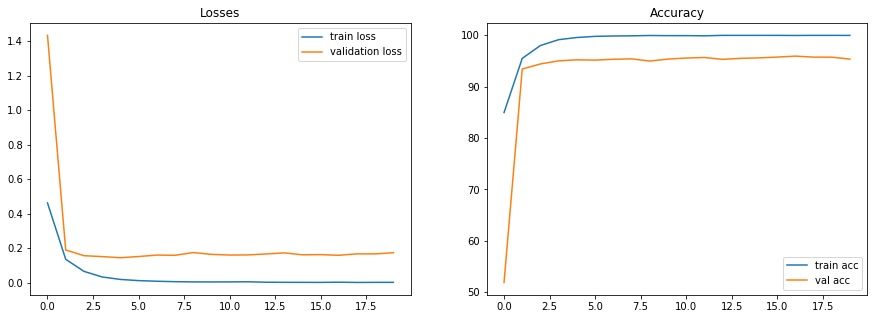

In [16]:
# Plot accuracy and loss for train and val both 
import matplotlib.pyplot as plt
def plot_acc_loss(loss_acc):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    x_range = np.arange(epochs)
    plt.plot(x_range, loss_acc['train_loss'], label = 'train loss')
    plt.plot(x_range, loss_acc['val_loss'], label = 'validation loss')
    plt.title('Losses')
    plt.legend()

    plt.subplot(1,2,2)
    x_range = np.arange(epochs)
    plt.plot(x_range, loss_acc['train_acc'], label = 'train acc')
    plt.plot(x_range, loss_acc['val_acc'], label = 'val acc')
    plt.title('Accuracy')
    plt.legend()
    
plot_acc_loss(loss_acc)

In [17]:
# testing 
print(device)
evaluate(model.to(device), testdataloader, device)

cuda:0
Accuracy of the network on the test images: 84 %


### Implicit attention: Attention from neural network

#### install grad cam
!pip install torchcam

In [18]:
# Set your CAM extractor
from torchcam.methods import SmoothGradCAMpp
from torchvision.io.image import read_image
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import normalize, resize, to_pil_image

model = model.eval()
cam_extractor = SmoothGradCAMpp(model)

torch.Size([7, 7])


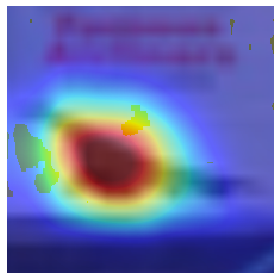

plane


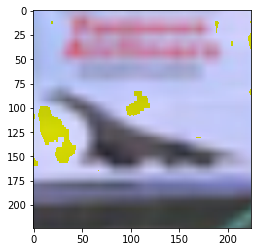

In [19]:
# from torchcam.methods import GradCAMpp
# cam_extractor = GradCAMpp(model, 'layer4')

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)
images, labels = next(iter(testdataloader))  
# # Preprocess it for your chosen model
idx = 3
input_tensor = images[idx]
img = inv_normalize(input_tensor)

# Preprocess your data and feed it to the model
out = model.to('cpu')(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

print(activation_map[0].shape)

# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0], mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()
plt.imshow(to_pil_image(img))
print(classes[labels[idx]])

torch.Size([3, 1004, 1280])
torch.Size([3, 224, 224])
torch.Size([7, 7])


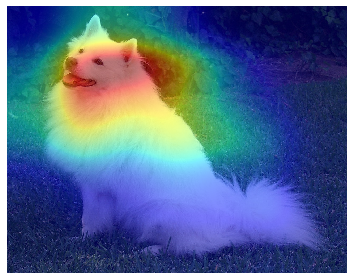

In [20]:
# Download and Tzry on new images 
img = read_image("/cdthome/hfk218/1280px-American_Eskimo_Dog.jpg")

print(img.shape)

# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

print(input_tensor.shape)

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

print(activation_map[0].shape)

# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0], mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

<h3>Try different combination, have fun playing...</h3>

Comments and feedback to: [Sharib Ali](sharib.ali@eng.ox.ac.uk)